In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import os
import pandas as pd
from tqdm import tqdm
import os
import requests
import json
import numpy as np
import urllib.parse

# Load pickle

In [3]:
df_netflix_imdb_tmdb = pd.read_pickle("netflix_imdb_tmdb.pickle")

In [4]:
with open("D:\OneDrive - Singapore Management University\credentials\\tmdb_api_key.txt") as f:
    api_key = f.read()

with open("D:\OneDrive - Singapore Management University\credentials\\tmdb_api_token.txt") as f:
    token = f.read()

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {token}"
}

In [5]:
class MyException(Exception):
    pass

In [6]:
def get_imdb_id_by_tmdb_id(tmdb_id):
    url = f"https://api.themoviedb.org/3/movie/{tmdb_id}/external_ids"
    response = requests.get(url, headers=headers)
    response = json.loads(response.text)
    return response['imdb_id']

def get_tmdb_id_by_imdb_id(imdb_id):
    url = f"https://api.themoviedb.org/3/find/{imdb_id}?external_source=imdb_id"
    response = requests.get(url, headers=headers)
    response = json.loads(response.text)
    response = response['movie_results']
    return response[0]['id'] if len(response) > 0 else None

In [7]:

def get_credits_by_tmdb_id(tmdb_id):
    url = "https://api.themoviedb.org/3/movie/{}/credits?language=en-US".format(tmdb_id)
    response = requests.get(url, headers=headers)
    response = json.loads(response.text)
    cast_ids = [cast['id'] for cast in response['cast']]
    # for cast in response['cast']:
    #     cast_ids.append(cast['id'])
    #     if cast['id'] not in df_credits_tmdb['tmdb_cast_id']:
    #         df_credits_tmdb.loc[len(df_credits_tmdb.index)] = [cast['id'], cast['name'], cast['original_name']]
    return cast_ids

def get_genres_by_tmdb_id(tmdb_id):
    url = "https://api.themoviedb.org/3/movie/{}?language=en-US".format(tmdb_id)
    response = requests.get(url, headers=headers)
    response = json.loads(response.text)
    genres = [genre['name'] for genre in response['genres']]
    # genre_ids = [genre['id'] for genre in response['genres']]
    return genres

In [8]:
df_netflix_tmdb = pd.DataFrame(columns=['netflix_id', 'tmdb_id', 'genres', 'cast'])

def get_netflix_tmdb(i):
    try:
        tid = df_netflix_imdb_tmdb.iloc[i]['tmdb_id']
        if tid is not None:
            cast = get_credits_by_tmdb_id(tid)
            genres = get_genres_by_tmdb_id(tid)
            df_netflix_tmdb.loc[len(df_netflix_tmdb.index)] = [i, tid, genres, cast]
        else:
            genres, cast = None, None
            df_netflix_tmdb.loc[len(df_netflix_tmdb.index)] = [i, tid, genres, cast]
    except Exception as error:
        print(i, tid, error)

In [35]:
from tqdm.contrib.concurrent import thread_map

df_netflix_tmdb = pd.DataFrame(columns=['netflix_id', 'tmdb_id', 'genres', 'cast'])

r = thread_map(get_netflix_tmdb, [i for i in range(17770)])

  0%|          | 0/17770 [00:00<?, ?it/s]

c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\pandas\core\dtypes\cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


131 None Shape of passed values is (119, 4), indices imply (117, 4)
276 52671 Shape of passed values is (276, 4), indices imply (275, 4)
387 90044 Shape of passed values is (385, 4), indices imply (383, 4)
434 74192 Shape of passed values is (442, 4), indices imply (439, 4)
495 None Shape of passed values is (472, 4), indices imply (471, 4)
500 11963 Shape of passed values is (499, 4), indices imply (498, 4)
525 None Shape of passed values is (500, 4), indices imply (499, 4)
518 113815 Shape of passed values is (516, 4), indices imply (514, 4)
544 None Shape of passed values is (517, 4), indices imply (516, 4)
646 18973 Shape of passed values is (638, 4), indices imply (637, 4)
700 None Shape of passed values is (667, 4), indices imply (665, 4)
726 36491 Shape of passed values is (710, 4), indices imply (709, 4)
751 None Shape of passed values is (714, 4), indices imply (713, 4)
3906 None Shape of passed values is (3839, 4), indices imply (3838, 4)
3908 None Shape of passed values is (

In [43]:
df_netflix_tmdb.to_pickle('netflix_tmdb_info.pickle')
df_netflix_tmdb.to_csv("netflix_tmdb_info.csv")

In [130]:
# df_netflix_tmdb = pd.read_pickle('netflix_tmdb_info.pickle')
df_netflix_tmdb = df_netflix_tmdb.sort_values(by='netflix_id')
df_netflix_tmdb = df_netflix_tmdb.reset_index(drop=True)
df_netflix_tmdb = df_netflix_tmdb.replace({np.nan: None})
# df_netflix_tmdb["netflix_id"] = df_netflix_tmdb.apply(lambda x: int(x['netflix_id']+1), axis=1)

df_netflix_tmdb

,netflix_id,tmdb_id,genres,cast
0,0.0,None,None,None
1,1.0,None,None,None
2,2.0,17139.0,"[History, Drama]","[13514, 45754, 79448, 143010, 1241993, 21450, ..."
3,3.0,274766.0,[],[129193]
4,4.0,33209.0,[Documentary],"[238321, 569184, 567264, 568555, 1222693, 5673..."
...,...,...,...,...
17765,17765.0,175484.0,"[Animation, Family, Fantasy]","[2209139, 110564]"
17766,17766.0,None,None,None
17767,17767.0,20004.0,[Science Fiction],"[18181, 128012, 31070, 2719, 152705, 62893, 10..."
17768,17768.0,52036.0,"[Romance, Music, Drama]","[9206, 56890, 17051, 145204, 36095, 146281, 14..."


In [127]:
missing = [x for x in range(17770) if x not in df_netflix_tmdb['netflix_id'].values]
print(len(df_netflix_tmdb), len(missing), missing)

17770 0 []


In [126]:
from tqdm.contrib.concurrent import thread_map

# df_netflix_tmdb = pd.DataFrame(columns=['netflix_id', 'tmdb_id', 'genres', 'cast'])

r = thread_map(get_netflix_tmdb, [i for i in missing])

  0%|          | 0/6 [00:00<?, ?it/s]

In [133]:
df_netflix_tmdb.to_pickle('netflix_tmdb_info.pickle')

In [131]:
df_netflix_tmdb["netflix_id"] = df_netflix_tmdb.apply(lambda x: int(x['netflix_id']+1), axis=1)

In [132]:
df_netflix_tmdb

,netflix_id,tmdb_id,genres,cast
0,1,None,None,None
1,2,None,None,None
2,3,17139.0,"[History, Drama]","[13514, 45754, 79448, 143010, 1241993, 21450, ..."
3,4,274766.0,[],[129193]
4,5,33209.0,[Documentary],"[238321, 569184, 567264, 568555, 1222693, 5673..."
...,...,...,...,...
17765,17766,175484.0,"[Animation, Family, Fantasy]","[2209139, 110564]"
17766,17767,None,None,None
17767,17768,20004.0,[Science Fiction],"[18181, 128012, 31070, 2719, 152705, 62893, 10..."
17768,17769,52036.0,"[Romance, Music, Drama]","[9206, 56890, 17051, 145204, 36095, 146281, 14..."


In [136]:
df_netflix_all = pd.read_pickle("netflix_all.pickle")

In [139]:
df_netflix_all['tmdb_cast'] = df_netflix_tmdb['cast']

<AxesSubplot:>

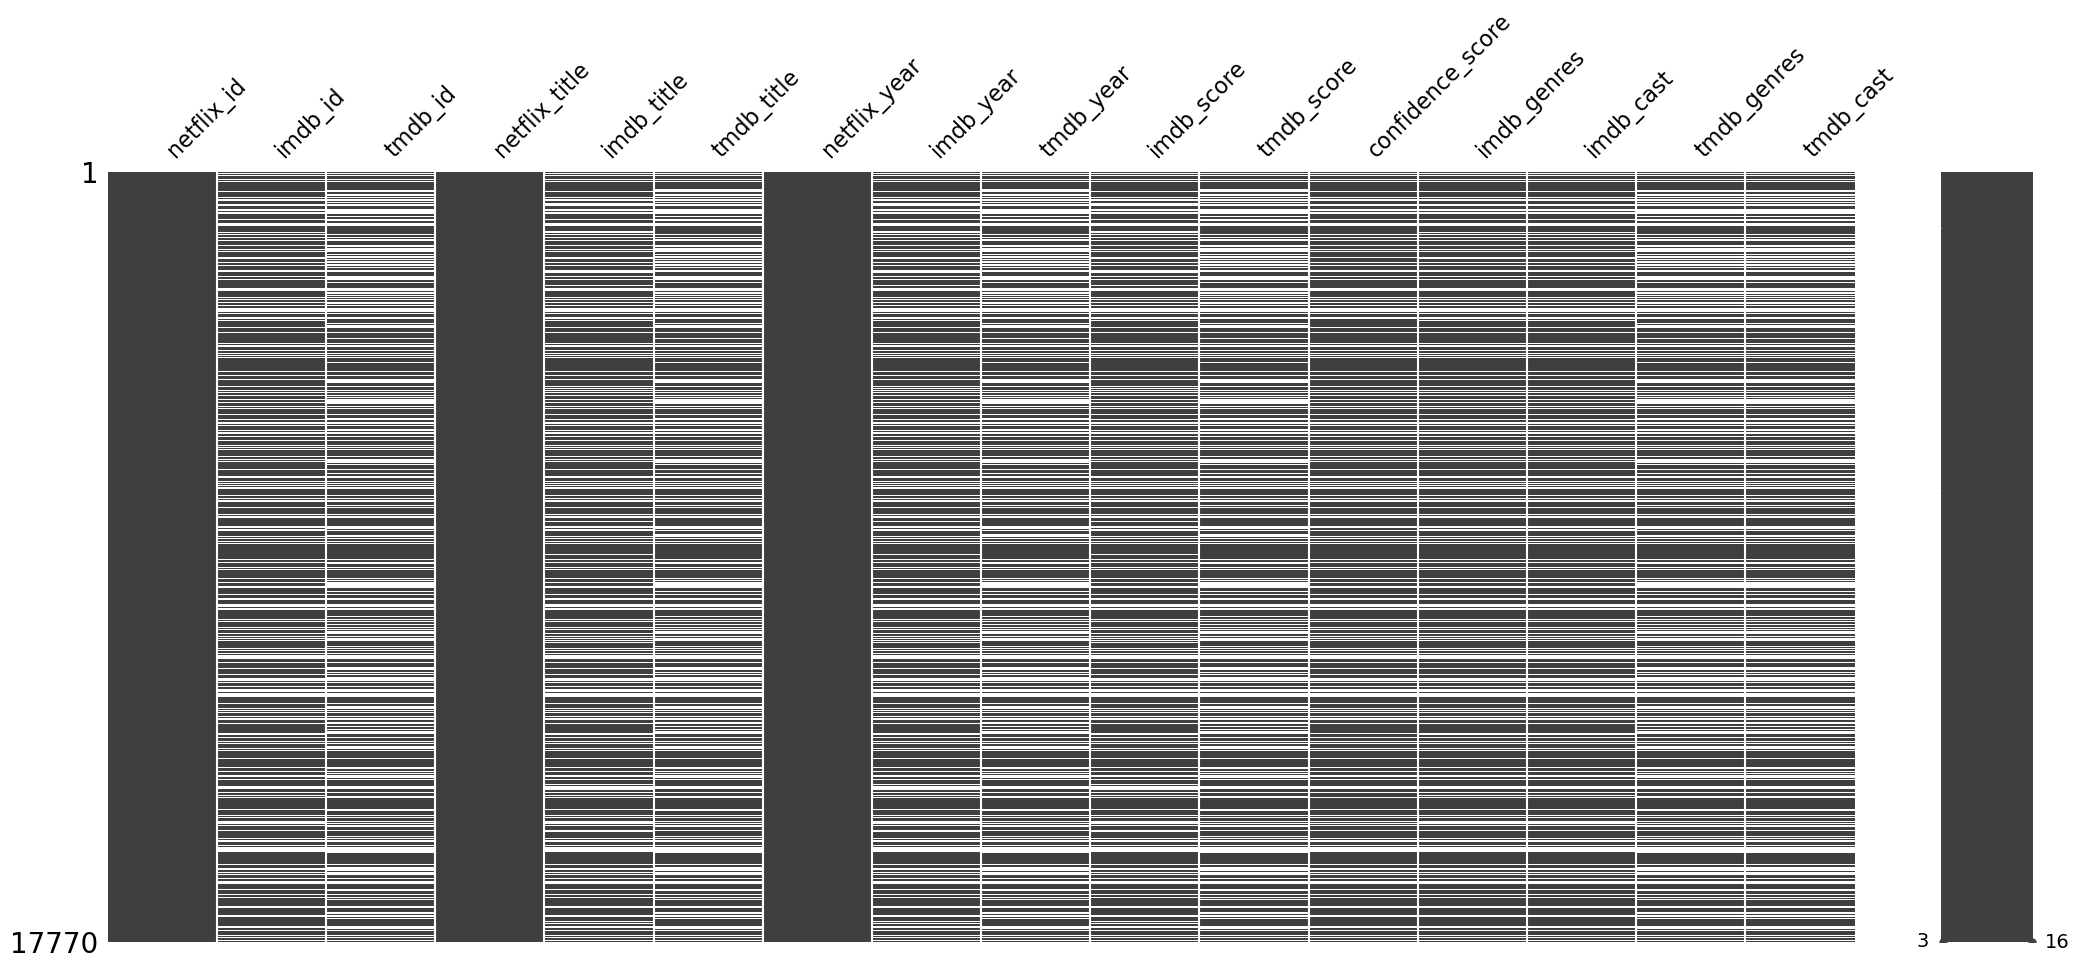

In [148]:
import missingno as msno

msno.matrix(df_netflix_all)

<AxesSubplot:>

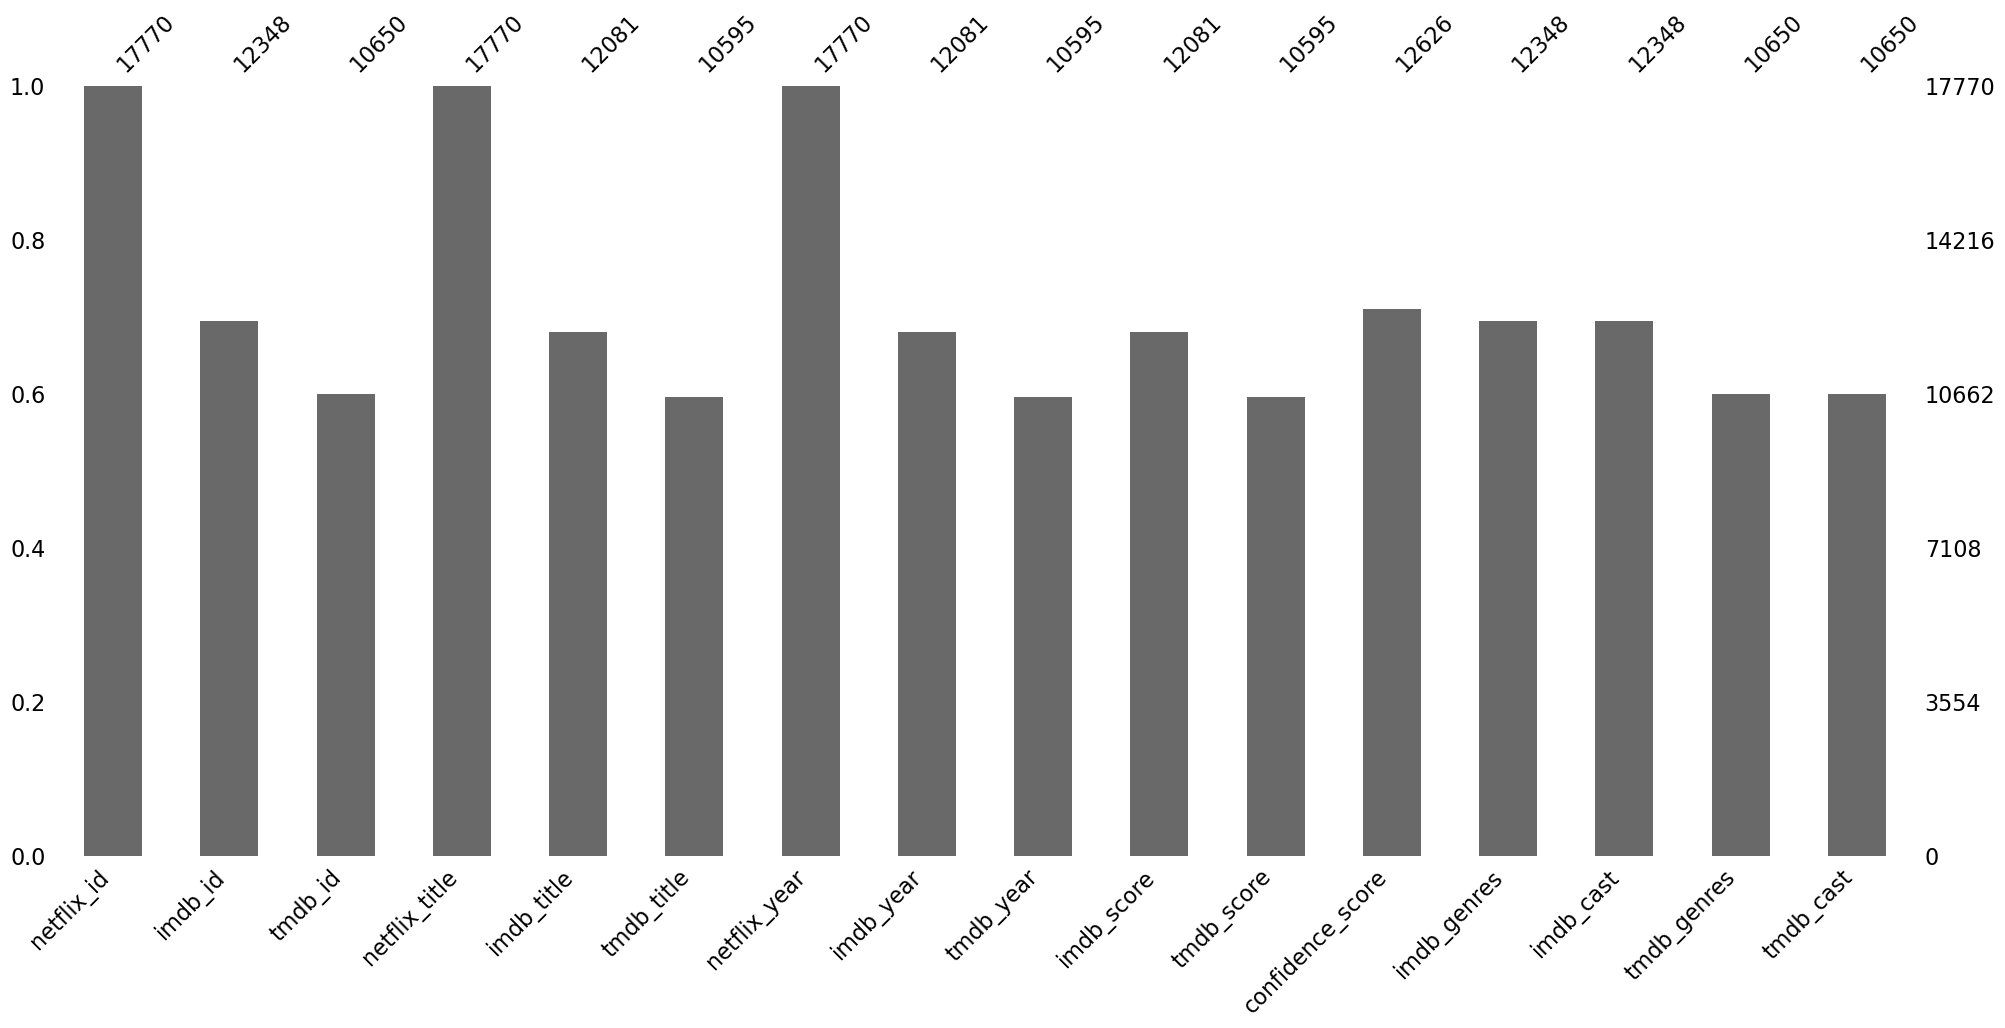

In [147]:
msno.bar(df_netflix_all)

In [143]:
df_netflix_all.to_pickle('netflix_all.pickle')
df_netflix_all.to_csv('netflix_all.csv')

In [145]:
df_netflix_all = df_netflix_all.replace({np.nan: None})

In [146]:
df_netflix_all

,netflix_id,imdb_id,tmdb_id,netflix_title,imdb_title,tmdb_title,netflix_year,imdb_year,tmdb_year,imdb_score,tmdb_score,confidence_score,imdb_genres,imdb_cast,tmdb_genres,tmdb_cast
0,1,tt0389605,None,Dinosaur Planet,Dinosaur Planet,None,2003,2003,None,1.0,None,1.0,"[Documentary, Animation, Family]","[0000225, 1503380, 0886833, 0726108, 0847799, ...",None,None
1,2,None,None,Isle of Man TT 2004 Review,None,None,2004,None,None,None,None,None,None,None,None,None
2,3,tt0119448,17139,Character,Character,Character,1997,1997,1997,1.0,1.0,1.0,"[Crime, Drama, Mystery, Thriller]","[0213912, 0404806, 0776926, 0233288, 0530564, ...","[History, Drama]","[13514, 45754, 79448, 143010, 1241993, 21450, ..."
3,4,tt0276981,274766,Paula Abdul's Get Up & Dance,Get Up and Dance!,Paula Abdul's Get Up & Dance,1994,1994,1994,0.577778,1.0,1.0,[Family],"[0000716, 0019844, 0092034, 0310969, 0641851]",[],[129193]
4,5,tt0440751,33209,The Rise and Fall of ECW,The Rise & Fall of ECW,WWE: The Rise + Fall of ECW,2004,2004,2004,0.913043,0.823529,0.913043,"[Documentary, Sport]","[1046786, 0010662, 0019155, 0019178, 0029875, ...",[Documentary],"[238321, 569184, 567264, 568555, 1222693, 5673..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17765,17766,None,175484,Where the Wild Things Are and Other Maurice Se...,None,Where the Wild Things Are... and other Maurice...,2002,None,2001,None,0.812325,0.812325,None,None,"[Animation, Family, Fantasy]","[2209139, 110564]"
17766,17767,None,None,Fidel Castro: American Experience,None,None,2004,None,None,None,None,None,None,None,None,None
17767,17768,tt0233657,20004,Epoch,Epoch,Epoch,2000,2001,2001,0.833333,0.833333,0.833333,"[Sci-Fi, Thriller]","[0001418, 0633318, 0641939, 0859921, 0094047, ...",[Science Fiction],"[18181, 128012, 31070, 2719, 152705, 62893, 10..."
17768,17769,tt0335013,52036,The Company,The Company,The Company,2003,2003,2003,1.0,1.0,1.0,"[Drama, Music, Romance]","[0000117, 0000532, 0290556, 0731732, 0225298, ...","[Romance, Music, Drama]","[9206, 56890, 17051, 145204, 36095, 146281, 14..."
